In [8]:
# Import some libraries from python and set some defaults
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
# from scipy.interpolate import CubicSpline
import pickle
import copy
from DEq_Solver import DEq_Solver
# import the solvers from the previous sessions
from DEq_Solver import DEq_Solver
from solvers import RK2Solver
from solvers import RK4Solver
from solvers import EulerSolver
import solvers
#set the font size for plots
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')

In [15]:
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="test_ballistic";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve') or os.path.isfile('.choices.shelve.dir'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None

def make_value_change_fn(assessmentName,name):
    def fn(change):
        s=shelve.open('.choices.shelve')
        key='{0}_{1}'.format(assessmentName,name)
        s[key]=change['new']
        s.close()
    return fn
 
class myFloatBox:
    def __init__(self,name,description,long_description):
        self.name=name
        self.description=description
        self.long_description=long_description
    def getWidget(self):
        self.widgets=[ 
              widgets.FloatText(
              description=self.description,
        disabled=False,
                  value=get_last_value('{0}_{1}'.format(assessmentName,self.name))
        )]
        
        txt=widgets.HTMLMath(
            value=self.long_description,
            placeholder='',
            description='',
        )
        
        self.widget=VBox([txt]+self.widgets)
        self.widgets[0].observe(make_value_change_fn(assessmentName,self.name), names='value')

        return self.widget
    



# Preamble: workshop notebooks

Work through this notebook cell by cell.

When working on your solution, you can save the notebook as many times as you like. You can also submit 
as many times as you like. In fact, it is a good idea to save and submit often.

**Validate** the notebook before submitting. Use the *validate* button in the browser

**Do not copy or delete one of the original cells**. Doing so means you cannot validate the notebook.
If required, *create a new cell*, and copy the *contents* of another cell.


**Only the last submission before the deadline** will be marked.
Note that you have to **submit** at least once for your work to be marked.


The notebook contains cells with code. Some of the code is (intentionally) missing. Please insert appropriate code below the line 'YOUR CODE HERE'. Cells which do not contain any 'YOUR CODE HERE' lines will allow you to test your code; if they return an error there is something wrong with your implementation; if they do not return an error your code might be correct (it is unfortunately not possible to check for every possible error).

Note:

simply add numerical value in a dropbox for it to get marked

when asked for true/false in a box:

ticking a box means True
not ticking (or ticking an even number of times) yields False


## Workshop III: Harmonic motion

In this workshop we implement several solvers that integrate the equation of motion of a pendulum.
We consider both a linear pendulum, with friction and driving, and a non-linear pendulum.

The coordinates of the pendulum are the angle measured from the vertical ($\theta$ in the notes), and its time derivative ($\dot\theta={\rm d}\theta/{\rm d}t$). In the implementation below, $\theta$ and $\dot\theta$ are the first and second entry of the state vector $x$:

` x=np.array([theta, dtheta/dt]) `


** Total marks is out of 50 **

## Simple harmonic motion

Simple harmonic motion is of the form

$$
\theta(t) = A\,\cos(\omega t+\phi)\,,
$$

where the amplitude, $A$, the angular frequency, $\omega$, and the phase-angle, $\phi$ are all constants.
In the case of a pendulum, $A$ is an angle. For **simple harmonic motion**, we assume that the extent $|\theta|$ is always small, $|\theta|\ll 1$, so that we can make the small angle approximation, $\theta\approx\sin(\theta)$.

In this assignment, we will initialize the pendulum by specifying $\theta_0=\theta(t=0)$ and letting the pendulum go without giving it an initial velocity.

The derivative of $\theta(t)$ is

$$
\dot\theta(t) = -\omega\,A\,\sin(\omega t + \phi)\,.
$$

If the initial velocity is $\dot\theta=0$, this means that $\phi=0$, and therefore $A=\theta_0$. 

The phase-angle $\phi$ is, as any angle, determined up to $2\pi$ when expressed in radians. We will make the convention of specifying $\phi$ in the range $\phi\in [-\pi, \pi[$.

The angular frequency is

$$
\omega = \left(\frac{g}{L}\right)^{1/2}\,
$$

where $g$ is the Earth's acceleration and $L$ the length of the pendulum. Both are given constants.


We begin by examining what it means for the *angle to be small*.



/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


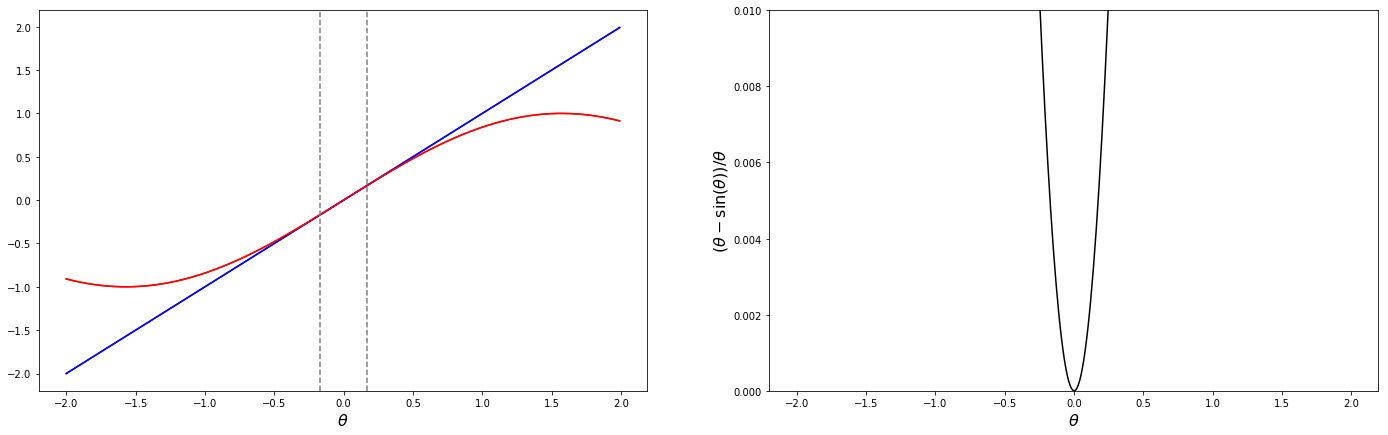

In [10]:
# Use the cell below to examine when we can make the small angle approximation

theta = np.arange(-2,2,0.01)   # use these angles, in radians

fig, ax = plt.subplots(1, 2, figsize = (24, 7))

label = 'theta'
ax[0].plot(theta, theta, color='blue', label = r"$\theta$")
ax[0].plot(theta, np.sin(theta), color='red', label=r"$\sin(theta)$")
ax[0].set_xlabel(r"$\theta$")

diff = theta - np.sin(theta)
ax[1].plot(theta, diff/theta, color='black')
ax[1].set_ylabel(r"$(\theta-\sin(\theta))/\theta$")
ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylim([0, 0.01])

ax[0].plot(theta, theta, color='blue', label = r"$\theta$")
ax[0].plot(theta, np.sin(theta), color='red', label=r"$\sin(theta)$")
ax[0].set_xlabel(r"$\theta$")


# now compute the largest positive value of theta for which theta=sin(theta) to better that 0.5 per cent.
# use the values of theta generated above
# plot the corresponding point (theta, sin(theta)) on the graph below
# YOUR CODE HERE

array = np.sin(theta)/theta

array2 = (theta-np.sin(theta))/theta *100

new_array2 = []
for i in range(len(array2)):
    if array2[i]<0.5:
        new_array2.append(theta[i])      
        
Max_plus_theta2 = max(new_array2)
Max_minus_theta2 = -max(new_array2)

ax[0].axvline(Max_plus_theta2,linestyle ='--',color = 'grey')
ax[0].axvline(Max_minus_theta2,linestyle ='--', color = 'grey')

fig.show()


In [16]:
import mywidgets
from IPython.display import display, HTML
HM0=myFloatBox('HM0',r"$\theta_{\rm max}$=",r"Enter the value of the maximum angle, $\theta_{\rm max}$, in radians to 3 significant figures")
HM0.getWidget()

### Class Pendulum

 
In the cell below, we will create a class `Pendulum`. It will contain methods for the (original) Euler, for the Runge-Kutta method, and for the Euler-Cromer timestepping method. We will implement `dx_dt(self,x,t)` for the first two, and `dx_dt_EC(self,x,t)` for the EC-solver. Within a the class, you have access to


    self.x        - the state vector
    self.t        - the time
    self.delta_t  - the time step
    
    self.L        - pendulum's length
    self.g        - gravity acceleration
    self.FD       - driving acceleration, F_d/m
    self.OD       - driving frequency
    self.q        - friction coefficient
    self.nonlin   - boolean that determines whether pendulum is linear (nonlin=false: small-angle approximation) or non-linear (nonlin=true)

Start by completing the missing code.

In [12]:
# physical constants used below, g is average gravitational acceleration on Earth's surface
phys_const = {'g':9.81}  # units [m/s^2]

In [13]:
class Pendulum:
    def __init__(self, L, q=0, F_D=0, Omega_D=0, nonlinear=False):
        """Initialize a pendulum object with 
        length L [m], 
        friction coefficient q [1/s], 
        driving acceleration amplitude F_D [N/kg],
        frequency Omega_D [s^-1]. 
        and a boolean switch to enable the nonlinear pendulum"""
        self.L      = float(L)
        self.q      = float(q)
        self.FD     = float(F_D)
        self.OD     = float(Omega_D)
        self.nonlin = nonlinear
        self.g      = phys_const["g"]             # gravitational acceleration on the Earth's surface [m/s^2]

    def dx_dt(self,x,t):
        # calculate the time derivative for 
        #      - the position, x[0]=theta
        #      - the angular velocity, x[1]=dtheta/dt
        # Note that angles are assumed to be in *radians*
        # Include gravity, friction and driving
        # Implement both linear (small-angle) and non-linear (no small-angle approximation) cases
        # Input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
        #       note: input x should be in the form of a numpy array
        # Returns: dx/dt = [dtheta/dt, d^2theta/dt^2]: speed and acceleration of the pendulum
        #      note: function should return dx/dt as an numpy array
        # YOUR CODE HERE
        dx_dt = np.array([x[0],x[1]])
        
        Omega_squared = (phys_const["g"]/self.L)
        
        if self.nonlin:
            dx_dt[0] = x[1]
            dx_dt[1] = -Omega_squared*np.sin(x[0]) - self.q*x[1] + self.FD*np.sin(self.OD * t)
        else:
            dx_dt[0] = x[1]
            dx_dt[1] = -Omega_squared*x[0] - self.q*x[1] + self.FD*np.sin(self.OD * t)
        return dx_dt
        
       
    def analytic(self,theta0,t):
        return theta0 * np.cos(np.sqrt(self.g/self.L) * t)

    def T(self,x):
        # Compute the kinetic energy per unit mass of the pendulum
        #     note that with have assumed that this mass of the pendulum = 1
        # input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
        # returns: kinetic energy / mass of pendulum
        #
        theta     = x[0]
        dtheta_dt = x[1]
        # YOUR CODE HERE
        return 0.5 * self.L**2 * x[1]**2
        
    def U(self,x):
        # Compute the potential energy per unit mass of the pendulum
        #     note that with have assumed that this mass of the pendulum = 1
        # Note: the expression for U for the linear and non-linear cases are not the same.
        # input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
        # returns: potential energy / mass of pendulum
        #
        theta     = x[0]
        dtehta_dt = x[1]
        U     = 0.0
        if self.nonlin:
            # Compute U for the non-linear case
            # YOUR CODE HERE
            U = phys_const["g"] * self.L * (1-np.cos(x[0]))
        else:
            # Compute U for the linear (small angle) case
            # YOUR CODE HERE~
            U = 0.5 * phys_const["g"] * self.L * x[0]**2
        
        return U


The next hidden cell verifies your dx_dt implementation.

** 5 marks **


In [14]:
# this tests the dx_dt implementation
testPend=Pendulum(2.3,1.1,0.5,2.2,False)
testPendNL=Pendulum(2.3,1.1,0.5,2.2,True)
assert np.isclose(testPendNL.dx_dt([0.5,0.3],0.7),[ 0.3, -1.87509123]).all()
assert np.isclose(testPend.dx_dt([0.5,0.3],0.7),[ 0.3, -1.96284578]).all()

The next hidden cell verifies your calculation of the potential and kinetic energy.

** 5 marks **


In [15]:
#this tests the energy implementation
assert np.isclose(testPend.U([0.5,0.3]),2.820375)
assert np.isclose(testPend.T([0.5,0.3]),0.23805)
assert np.isclose(testPendNL.U([0.5,0.3]),2.7621)
assert np.isclose(testPendNL.T([0.5,0.3]),0.23805)

Below we define the Euler-Cromer solver. The class EulerCromerSolver is derived from the more general DEq_Solver class (see DEq_Solver.py in this directory). This means that the resulting EulerCromerSolver class features all the methods defined in DEq_Solver as well as the additional EulerCromerSolver methods which you are supposed to complete below. 

Implement the makeStep(self) function. Within this function you have access to 

- the current coordinates array as ``self.x``
- the current time as ``self.t``
- the derivative $dx/dt$ as ``self.kernel.dx_dt(self.x,self.t)``
- the timestep as ``self.delta_t``

the function ``makeStep`` has to update ``self.x`` and ``self.t``.
 

In [16]:
class EulerCromerSolver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        # this should implement the EC step, as before you have access to
        # You can access
        # time as self.t
        # the time step as self.delta_t
        # the position and velocity as the vector self.x
        # the derivative of x, dx/dt, as the kernel self.kernel.dx_dt
        # output: none
        # makeStep changes the state vector
        #   - update time by the time step
        #   - update x given its time derivative, kernel.dx_dt
        # make sure you update position and velocity in the manner consistent with the Euler-Cromer method
        # YOUR CODE HERE
    
        
        self.x[1] = self.x[1] + self.kernel.dx_dt(self.x,self.t)[1]*self.delta_t
        
        self.x[0] = self.x[0] + self.x[1]*self.delta_t
        
        self.t += self.delta_t
        
        
        

The hidden cell below tests the implementation of the EulerCromer solver. 

** 5 marks**

In [17]:
# this tests the EC step
testEC=EulerCromerSolver(testPend)
testEC.x=[0.3,0.2]
testEC.t=0
testEC.delta_t=0.01
testEC.makeStep()
assert np.isclose(testEC.t,0.01)
assert np.isclose(testEC.x,[ 0.30185004,  0.18500435]).all()

## Simple harmonic motion

We begin by examining the behaviour of the pendulum and our integrators in the *linear* case, that is, making the small-angle approximation (nonlin=False)

The cell below evolves such a linear-pendulum, and plots angle and energy as a function of time 

In [18]:
def makePlots(solver,
              dt       = 0.02,  # time step size
              t0       = 0.,    # start time t1 (s)
              t1       = 100.,  # End time t1 (s)
              theta0   = 10,    # initial angle (deg)
              logscale = False  # logscale for energy plot 
             ):
    '''
    This function creates the two plots 
      theta vs time  
      energy vs time
    '''

    # this sets the initial conditions
    x0 = np.array([theta0 * np.pi / 180., 0])

    result       = solver.solve(x0, t0, t1, dt)
    ts           = solver.timeSteps()
    coords       = solver.coordinateSteps()
    rads, omegas = coords   
    degrees = 180. * rads / np.pi
    fig, ax = plt.subplots(1, 2, figsize = (20, 7))

    fig.suptitle('Pendulum. $L$=%s m; $q$=%s/s; $F_D$=%s$/\mathsf{s}^2$, $\Omega_D$=%s/s'
            %(
                solver.kernel.L,
                solver.kernel.q,
                solver.kernel.FD,
                solver.kernel.OD))
    
    #plot angle vs. time
    ax[0].plot(ts, degrees)
    ax[0].set_ylabel(r'$\theta [\mathrm{deg}]$')
    ax[0].set_xlabel(r'$t [\mathrm{s}]$')
    
    Ts = [ pend.T(x) for x in zip(rads,omegas) ]
    Us = [ pend.U(x) for x in zip(rads,omegas)  ]
    Es = [ a + b for a, b in zip(Ts,Us) ]

    ax[1].plot(ts, Ts, 'b', label='$E_{kin}$')
    ax[1].plot(ts, Us, 'g', label='$E_{pot}$')
    ax[1].plot(ts, Es, 'r', label='$E_{tot}$')

    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Energy [J/kg]')
    if logscale:
        ax[1].set_yscale('log')
    ax[1].legend()    

### Integrate the pendulum using Euler's method

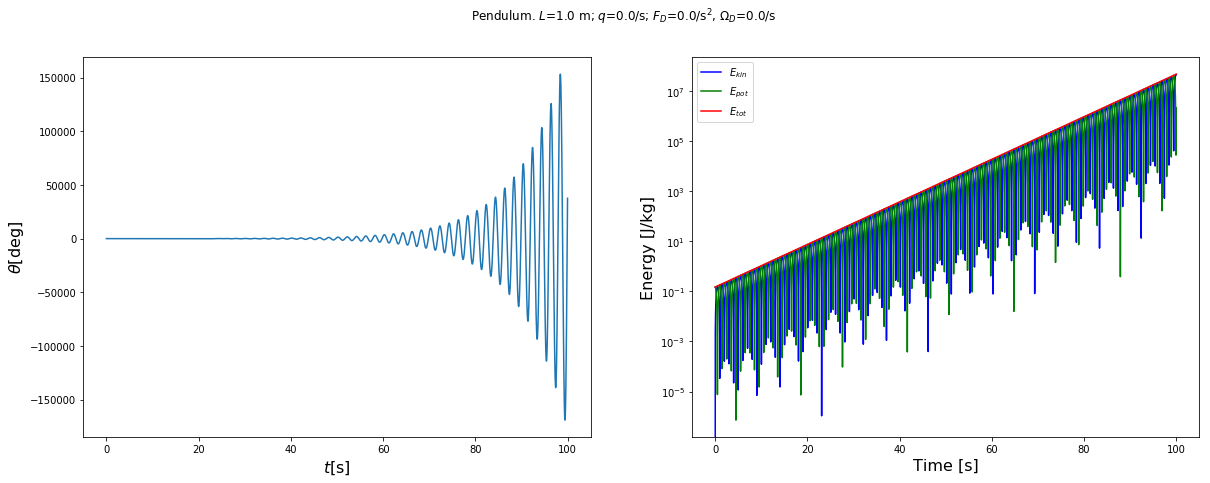

In [19]:
# Run Euler's method and make the plots
pend = Pendulum(
                L=1.0,
                q=0,
                F_D=0,
                Omega_D=0,
                nonlinear=False)
solver = solvers.EulerSolver(pend)

makePlots(solver, logscale = True)

### Integrate the pendulum using RK 2

In this part we use the same pendulum model as before, but use the Runge-Kutta solver. It was already implemented in a previous exercise, so it is provided here in the solvers module.

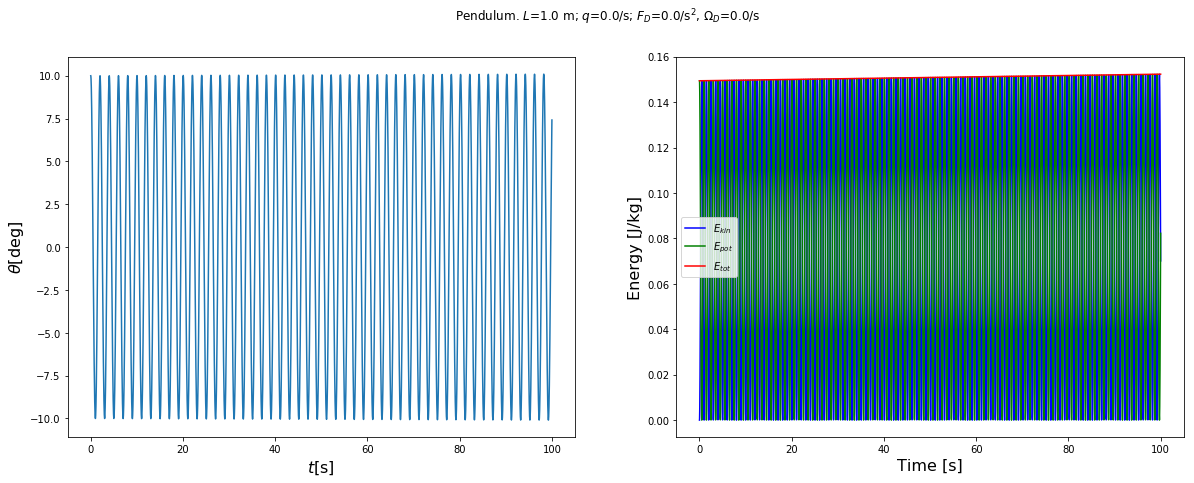

In [20]:
# Run RK2 on the same pendulum, and make the plots
solver = solvers.RK2Solver(pend)
makePlots(solver)

Put a tick mark in the boxes that are true. No tick means answer is false.

** 5 marks **



In [17]:
import mywidgets
from IPython.display import display, HTML
mcb=mywidgets.myCheckBoxSet('Harmonic','RK1',
                            'Which of the following assertions are true?',[
                                'The Runge-Kutta solver performs is more stable than the Euler solver for this problem',
                                'The amplitude grows exponentially for the RK2 solver.',
                                'For $\Delta t=0.001$ the RK2 solver is stable for $t_0=0$ and $t_1=100$.',
                                'The RK2 method is stable for all $t$.'
                            ])
mcb.getWidget()

In [22]:
display(HTML('<hr>'))

### Integrate the pendulum using RK 4

We repeat the same exercise but using the RK4 solver. It was already implemented in a previous exercise, so it is provided here in the solvers module.

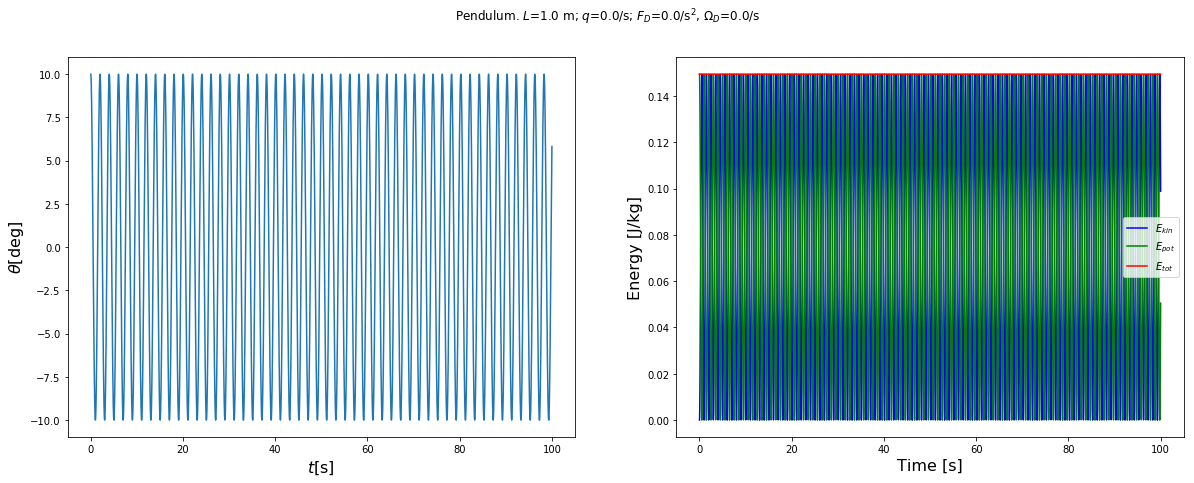

In [23]:
# Run RK4 on the same pendulum, and make the plots
solver = solvers.RK4Solver(pend)
makePlots(solver)

Put a tick mark in the boxes that are true. No tick means answer is false.

**5 marks**

In [18]:
import mywidgets
from IPython.display import display, HTML
mcb2=mywidgets.myCheckBoxSet('Harmonic','RK4',
                            'Which of the following assertions are true?',[
                                'Energy conservation is better for the RK4 solver than for the RK2 solver for the same value of $\Delta t$',
                                'The RK4 solver peforms more operations than the RK2 solver for the same number of steps'
                            ])
mcb2.getWidget()

In [25]:
display(HTML('<hr>'))

### Integrate using Euler-Cromer's method

Integrate using your implemntation of Euler-Cromer's solver.

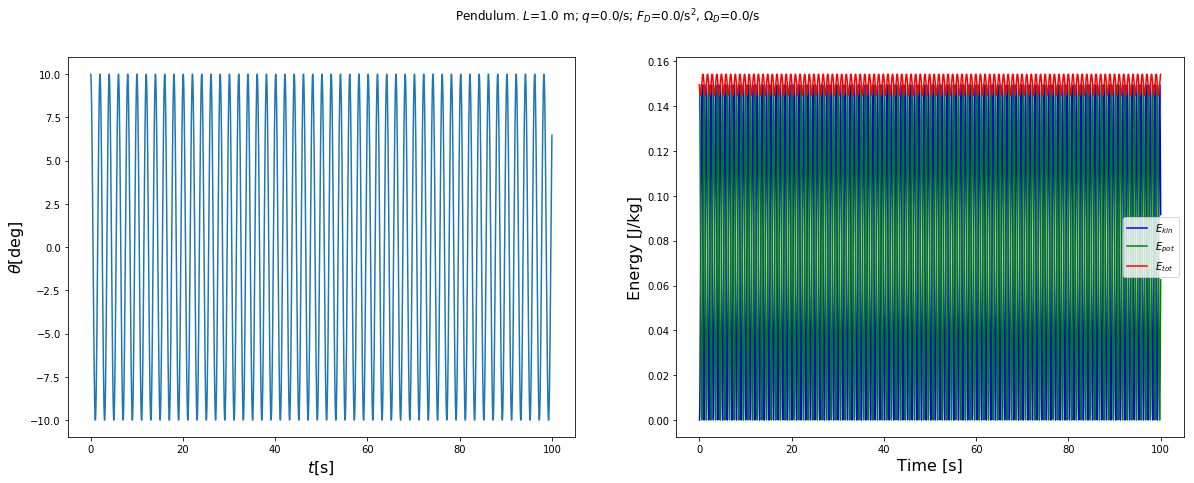

In [26]:
# Run EC on the same pendulum, and make the plots
ECsolver = EulerCromerSolver(pend)
makePlots(ECsolver,dt=0.02,t1=100)

In [19]:
import mywidgets
mcb3=mywidgets.myCheckBoxSet('Harmonic','EC',
                            'Which of the following assertions are true?',[
                                'The EC solver is less stable than RK2 for the same number of steps',
                                'The EC solver performs more operations than the RK2 solver for the same number of steps',
                                'The energy of the pendulum oscillates with an amplitude that depends on the value of $\Delta t$.',
                            ])
mcb3.getWidget()

In [28]:
display(HTML('<hr>'))

### Second method of investigation

In the second method, we do all calculation in one cell and store the results. We then examine the results in subsequent cells


In [29]:
# store the values of the pendulum as a dictionary

# parameters of the pendulum (gravity, Length, friction, driving force and frequency, non-linearity)                
pendulum_pars = {'g':phys_const["g"], 'L':1.0, 'q':0.0, 'F_D':0.0, 'Omega_D':0.0, 'non_linear':False}

# Compute the period
def Period(pendulum):
    if (pendulum["non_linear"]):
        omega = pendulum["Omega_D"]
    else:
        omega = np.sqrt(pendulum["g"]/pendulum["L"])
    return 2.*np.pi/omega

period = Period(pendulum_pars)
print("Period of pendulum = ", period)

# simulation parameters: launch angle (degrees), starting and end time, time-step
# Notice that we define the timestep and the end time, in units of the period (unlike in the first part of the analysis)
dt         = Period(pendulum_pars) / 2**6
simulation = {'theta_deg':10, 't0':0, 't1': 100.*period, 'dt':dt}

# list of integration methods, in the form of (method, name)
methods = [(EulerSolver, 'Euler'), (RK2Solver,'RK2'), (RK4Solver,'RK4'), (EulerCromerSolver, 'Euler-Cromer')]

# The dictionary store the outcomes
# Notice the use of "method" to store results for a specific method
Results = {}
for method in methods:
    name       = method[1]
    solverType = method[0]

    # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                    F_D=pendulum_pars["F_D"], Omega_D=pendulum_pars["Omega_D"], 
                    nonlinear=pendulum_pars["non_linear"])

    # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] * np.pi / 180., 0])

    #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps()      # angle, dangle/dt
    print("Finished calculation for solver = ", name)

    # Store output. For each method, we create another dictionary for storing the outcome
    Results[method] = {}
    Results[method]['t']          = ts
    Results[method]['theta']      = theta
    Results[method]['dtheta_dt']  = dtheta_dt
    Results[method]['period']     = period


Period of pendulum =  2.006066680710647
Finished calculation for solver =  Euler
Finished calculation for solver =  RK2
Finished calculation for solver =  RK4
Finished calculation for solver =  Euler-Cromer


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


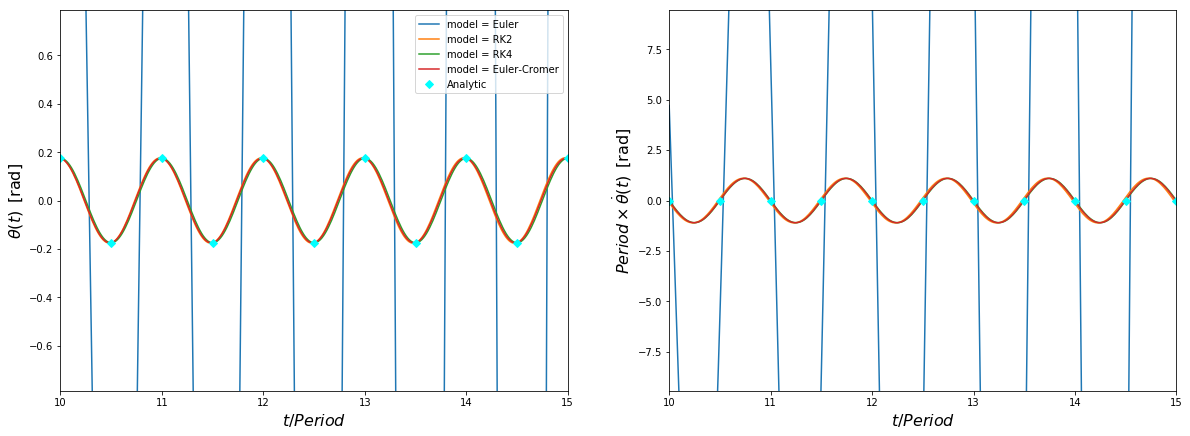

In [30]:
# make plots for all models

fig, ax = plt.subplots(1, 2, figsize = (20, 7))

nplot    = len(methods)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.CMRmap(np.linspace(0., 1., nplot+1))))
cycle    = plt.rcParams['axes.prop_cycle'].by_key()['color']
nsys     = np.arange(nplot)

# 
handles  = []
handles2 = []
for (isys, method) in zip(nsys, methods):
    color  = cycle[isys]
    name   = method[1]
    label  = r"model = {}".format(name)   # label to differentiate between models
    #
    if (isys == 0):
        period = Results[method]["period"]
    t          = Results[method]['t']                   # divide by period ot make it dimensionless 
    theta      = Results[method]['theta']
    dtheta_dt  = Results[method]['dtheta_dt'] * period
    ax[0].plot(t/period, theta,     color=color, label=label)
    ax[1].plot(t/period, dtheta_dt, color=color, label=label)   # multiply by period to make it dimensionless

# plot analytic solution
label       = 'Analytic'
nsteps      = 200
dt          = (simulation["t1"] - simulation["t0"]) / nsteps
times       = np.arange(simulation["t0"], simulation["t1"], dt)
omega       = 2.*np.pi / period    # angular frequency
theta       = simulation["theta_deg"] * np.pi/180. * np.cos(omega * times)
dtheta_dt   = -omega * simulation["theta_deg"] * np.pi/180. * np.sin(omega * times)
ax[0].plot(times/period, theta, 'D', color='cyan', label=label)
ax[1].plot(times/period, period * dtheta_dt, 'D', color='cyan', label=label)
    
ax[0].legend() 
xrange = [10,15]
for i in np.arange(2):
    ax[i].set_xlim(xrange)
    ax[i].set_xlabel(r"$t / Period$")    

ax[0].set_ylim([-np.pi/4, np.pi/4])
ax[0].set_ylabel(r"$\theta(t)\,\,\,[{\rm rad}]$")

ax[1].set_ylim([-3*np.pi, 3*np.pi])
ax[1].set_ylabel(r"$Period\times \dot\theta(t)\,\,\,[{\rm rad}]$")

fig.show()



A figure caption could read:

Left panel: angle $\theta$, in radians, as a function of time $t$, in units of the period. Different colours correspond to different integrators, with blue, yellow, green and red corresponding to Euler's method, RK2, RK4 and Euler-Cromer's method, respectively. Cyan diamonds: same, but for the analytic answer. Right panel: same as left panel, but showing the product of the period times $\dot\theta$, in radians.

What else would be useful to add to the figure or caption? What do you learn from the results?

An obvious difference between the solvers is that the amplitude for the Euler model grows in time much more than for the others. But maybe there are small, more subtle differences between the more accurate integrators as well?
To examine this, we can characterise the harmonic motion as
$$
\theta(t) = A\,\cos(\omega\,t+\phi)\,,
$$
where $A$ is the amplitude and $\phi$ the phase. When the motion is simply harmonic, $A$, $\phi$ & $\omega$ are constants.

They can be computed from the output in Results, by computing the first and second derivatives,
$$
\dot\theta(t) = -A\omega\sin(\omega t+\phi)\,;\quad \ddot\theta(t) = -A\omega^2\,\cos(\omega\,t+\phi)\,.
$$

Therefore, given the evolution of the system, $\theta(t)$, we can compute $A$, $\omega$ and $\phi$.
Please, perform the algebra to verify that


$$
\omega = \left(-\frac{\ddot\theta}{\theta}\right)^{1/2}\,;\quad 
\phi = \arctan2(-\frac{\dot\theta}{\omega}, \theta)\,;\quad A = \left(\theta^2+\left(\frac{\dot\theta}{\omega}\right)^2\right)^{1/2}\,,
$$
where $\arctan2$=numpy.arctan2.

Compute and plot $\omega$, $A$ and $\phi$ for RK2, RK4 and Euler-Cromer, from $t$/period=10-20.
Make two plots as above, and use a legend to distinguish the curves.

The cell below uses a simple example that illustrates how a *spline* fit can be used to compute numerical derivatives.
We will use the same method to compute $\dot\theta(t)$ and $\ddot\theta(t)$ from $\theta(t)$.



/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


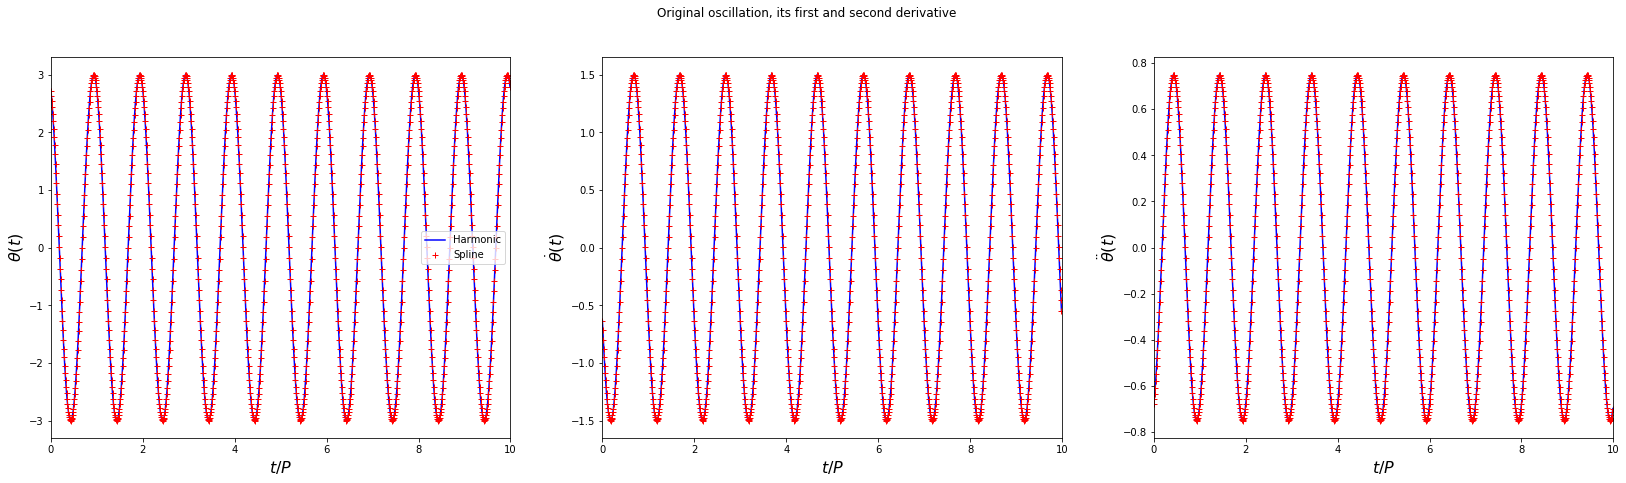

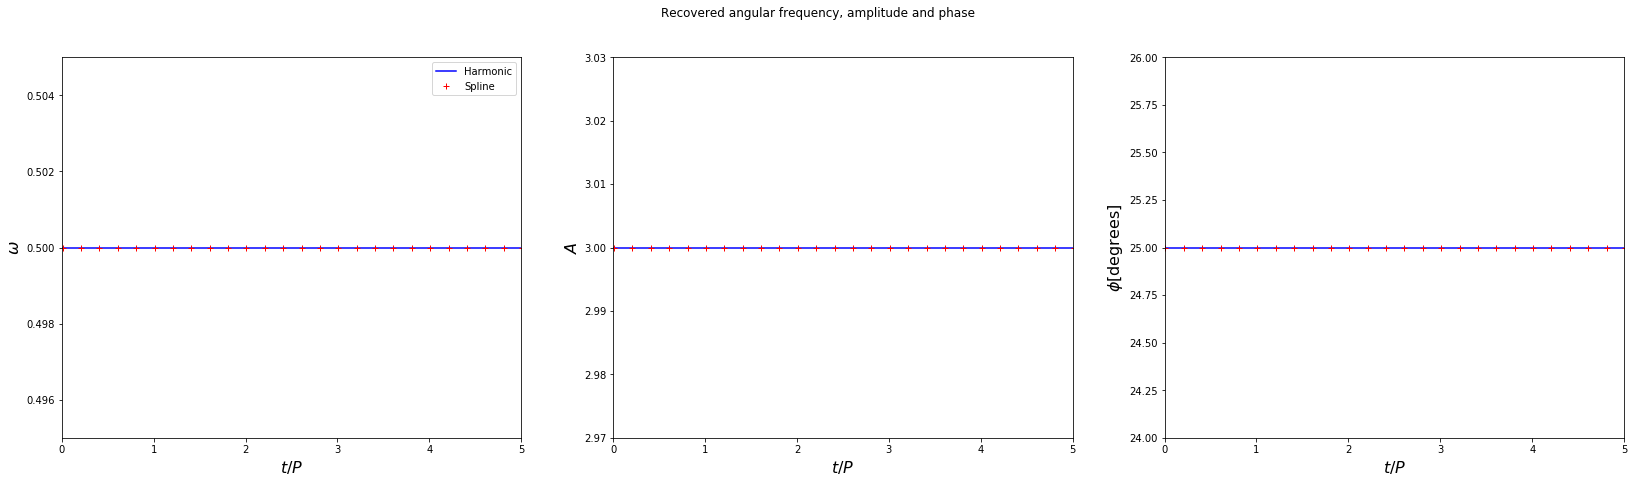

In [31]:
# This cell illustrates how to compute the phase, amplitude and angular frequency of a harmonic motion
# theta = amplitude * cos(omega t + phi)

# These are the input values
phi_deg   = 25.0 # phase angle in degrees
omega     = 0.5
amplitude = 3.0
period    = 2.*np.pi/omega
t0        = 0
t1        = 10.*period

# Computed properties
dt        = period / 100.
phi       = phi_deg /180. * np.pi
t         = np.arange(t0, t1, dt)

# analytical relation
theta       = amplitude * np.cos(omega*t+phi)
dtheta_dt   = -omega*amplitude * np.sin(omega*t+phi)
ddtheta_dt2 = -omega**2 *amplitude * np.cos(omega*t+phi)
analytical  = {'t':t, 'theta':theta, 'dtheta_dt':dtheta_dt, 'ddtheta_dt2':ddtheta_dt2}

# Now we calculate the derivatives numberically from the theta(t) array
# (1) First create a spline fit to theta(t), using the scipy function
#     UnivariateSpline(
# (2) Given the spline fit, compute the derivatives *of the spline*
from scipy.interpolate import UnivariateSpline         # import the scipy routine
spl            = UnivariateSpline(t, theta, k=4, s=0)  # create spline fit
dtheta_dt_sp   = spl.derivative(n=1)                   # create the first derivative of the spline
dtheta_dt      = dtheta_dt_sp(t)                       #    and evaluate it at the x-values t
ddtheta_dt2_sp = spl.derivative(n=2)                   # redo for the second derivative
ddtheta_dt2    = ddtheta_dt2_sp(t)
numerical      = {'t':t, 'theta':theta, 'dtheta_dt':dtheta_dt, 'ddtheta_dt2':ddtheta_dt2}




# First figure: compare theta(t), dtheta_dt(t), and ddtheta_dt2(t) between analytical input
#     and spline fits
fig, ax = plt.subplots(1, 3, figsize = (28, 7))
fig.suptitle('Original oscillation, its first and second derivative')

model = analytical; label  = 'Harmonic'; color  = 'blue'
ax[0].plot(model["t"]/period, model["theta"], color=color, label=label)
ax[1].plot(model["t"]/period, model["dtheta_dt"], color=color, label=label)
ax[2].plot(model["t"]/period, model["ddtheta_dt2"], color=color, label=label)

model = numerical; label  = 'Spline'; color  = 'red'
ax[0].plot(model["t"]/period, model["theta"], '+', color=color, label=label)
ax[1].plot(model["t"]/period, model["dtheta_dt"], '+', color=color, label=label)
ax[2].plot(model["t"]/period, model["ddtheta_dt2"], '+', color=color, label=label)

for i in np.arange(3):
    ax[i].set_xlim([0,10])
    ax[i].set_xlabel(r"$t / P$")
ax[0].set_ylim(amplitude * np.array([-1.1, 1.1]))
ax[1].set_ylim(omega * amplitude * np.array([-1.1, 1.1]))
ax[2].set_ylim(omega**2 * amplitude * np.array([-1.1, 1.1]))

ax[0].set_ylabel(r"$\theta(t)$")
ax[1].set_ylabel(r"$\dot\theta(t)$")
ax[2].set_ylabel(r"$\ddot\theta(t)$")
ax[0].legend()
fig.show()




# From spline fit to theta(t), compute A, omega and phi
#    Note the use of a dictionary to prevent confusion over which method we are using
omega_sp  = np.sqrt(-numerical["ddtheta_dt2"]/numerical["theta"])
A_sp      = np.sqrt(numerical["theta"]**2 + (numerical["dtheta_dt"]/omega_sp)**2)
phi_sp    = -omega_sp * t + np.arctan2(-numerical["dtheta_dt"]/omega_sp, numerical["theta"])
phi_sp    = np.mod(phi_sp, 2.*np.pi)  # limit to [0, 2pi]
  

# Second figure: compare correct answer to that obtained from numerical derivatives
fig, ax = plt.subplots(1, 3, figsize = (28, 7))
fig.suptitle('Recovered angular frequency, amplitude and phase')

label = 'Harmonic'
ax[0].plot(numerical["t"]/period, omega + 0*np.array(numerical["t"]), color='blue', label=label)
ax[1].plot(numerical["t"]/period, amplitude + 0*np.array(numerical["t"]), color='blue')
ax[2].plot(numerical["t"]/period, phi_deg + 0*np.array(numerical["t"]), color='blue')

#
label = 'Spline'
ax[0].plot(numerical["t"][1::20]/period, omega_sp[1::20], '+', color='red', label=label)
ax[1].plot(numerical["t"][1::20]/period, A_sp[1::20], '+', color='red')
ax[2].plot(numerical["t"][1::20]/period, phi_sp[1::20]/np.pi*180., '+', color='red')
for i in np.arange(3):
    ax[i].set_xlim([0,5])
    ax[i].set_xlabel(r"$t / P$")
ax[0].legend()
ax[0].set_ylim(omega * np.array([0.99, 1.01]))
ax[0].set_ylabel(r"$\omega$")
ax[1].set_ylim(amplitude * np.array([0.99, 1.01]))
ax[1].set_ylabel(r"$A$")
ax[2].set_ylim(phi_deg + np.array([-1, 1]))
ax[2].set_ylabel(r"$\phi [{\rm degrees}]$")

    
fig.show()


Finished calculation for solver =  RK4


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


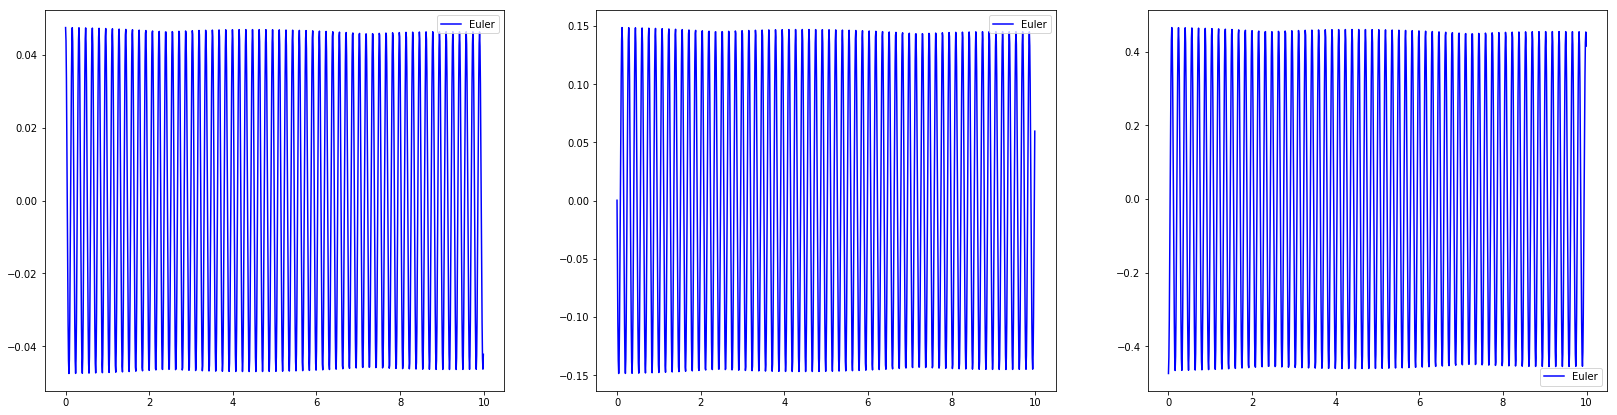

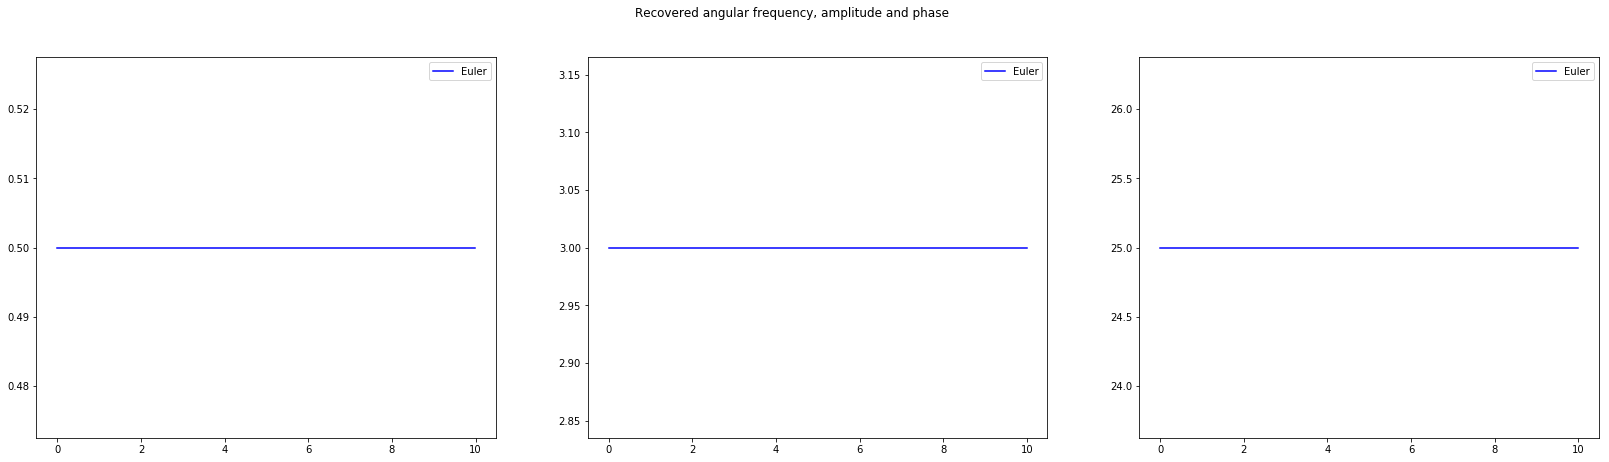

In [32]:
 from scipy.interpolate import UnivariateSpline  
    
    
    
# These are the input values
phi_deg   = 25.0 # phase angle in degrees
omega     = 0.5
amplitude = 3.0
period    = 2.*np.pi/omega
t0        = 0
t1        = 10.*period

# Computed properties
dt        = period / 100.
phi       = phi_deg /180. * np.pi
t         = np.arange(t0, t1, dt)    


# parameters of the pendulum (gravity, Length, friction, driving force and frequency, non-linearity)                
pendulum_pars = {'g':phys_const["g"], 'L':1.0, 'q':0.0, 'F_D':0.0, 'Omega_D':0.0, 'non_linear':False}



# simulation parameters: launch angle (degrees), starting and end time, time-step
# Notice that we define the timestep and the end time, in units of the period (unlike in the first part of the analysis)

simulation = {'theta_deg':10, 't0':t0, 't1': t1, 'dt':dt}

# list of integration methods, in the form of (method, name)
methods = [ (RK4Solver,'RK4')]
#methods = [(EulerCromerSolver, 'Euler-Cromer')]
# The dictionary store the outcomes
# Notice the use of "method" to store results for a specific method
Results = {}

fig, ax1 = plt.subplots(1, 3, figsize = (28, 7))

fig, ax = plt.subplots(1, 3, figsize = (28, 7))
fig.suptitle('Recovered angular frequency, amplitude and phase')
labelllss = ('Euler', 'RK2', 'RK4', 'Euler Cromer')
total = 0
color_ = 0
color = ('blue','red','black','green')




for method in methods:

    name       = method[1]
    solverType = method[0]

    # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                    F_D=pendulum_pars["F_D"], Omega_D=pendulum_pars["Omega_D"], 
                    nonlinear=pendulum_pars["non_linear"])

    # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] * np.pi / 180., 0])

    #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps()      # angle, dangle/dt
    print("Finished calculation for solver = ", name)
    
          # import the scipy routine
    spl            = UnivariateSpline(ts, theta, k=4, s=0)  # create spline fit
    dtheta_dt_sp   = spl.derivative(n=1)                   # create the first derivative of the spline
    dtheta_dt      = dtheta_dt_sp(ts)                       #    and evaluate it at the x-values t
    ddtheta_dt2_sp = spl.derivative(n=2)                   # redo for the second derivative
    ddtheta_dt2    = ddtheta_dt2_sp(ts)
    numerical      = {'t':ts, 'theta':theta, 'dtheta_dt':dtheta_dt, 'ddtheta_dt2':ddtheta_dt2}
    
    omega_sp  = np.sqrt(-numerical["ddtheta_dt2"]/numerical["theta"])
    A_sp      = np.sqrt(numerical["theta"]**2 + (numerical["dtheta_dt"]/omega_sp)**2)
    phi_sp    = -omega_sp * ts + np.arctan2(-numerical["dtheta_dt"]/omega_sp, numerical["theta"])
    phi_sp    = np.mod(phi_sp, 2.*np.pi)  # limit to [0, 2pi]

    ax1[0].plot(numerical["t"]/period, theta, color=color[total], label=labelllss[total])
    ax1[1].plot(numerical["t"]/period, dtheta_dt, color=color[total], label=labelllss[total])
    ax1[2].plot(numerical["t"]/period, ddtheta_dt2, color=color[total],label=labelllss[total])


    ax[0].plot(numerical["t"]/period, omega + 0*np.array(numerical["t"]), color=color[total], label=labelllss[total])
    ax[1].plot(numerical["t"]/period, amplitude + 0*np.array(numerical["t"]), color=color[total], label=labelllss[total])
    ax[2].plot(numerical["t"]/period, phi_deg + 0*np.array(numerical["t"]), color=color[total],label=labelllss[total])
    total+=1

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax1[0].legend()
ax1[1].legend()
ax1[2].legend()

#ax1[0].set_ylim(0,3)

fig.show()



Period of pendulum =  2.006066680710647
Finished calculation for solver =  Euler
Finished calculation for solver =  RK2
Finished calculation for solver =  RK4
Finished calculation for solver =  Euler-Cromer
###########
 [-1.69705149e+00 -1.71354221e+00 -1.71354237e+00 ...  3.39641311e+83
  3.80654693e+83  4.18696709e+83]
###########
 [-1.71777811 -1.70940597 -1.68467104 ...  1.97358584  2.14996035
  2.30677314]
###########
 [-1.71228566 -1.70390745 -1.67927176 ...  1.20672375  1.31982426
  1.42098556]
###########
 [-1.71371152 -1.69701121 -1.66416399 ...  1.13745489  1.00613905
  0.86420075]


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in sqrt


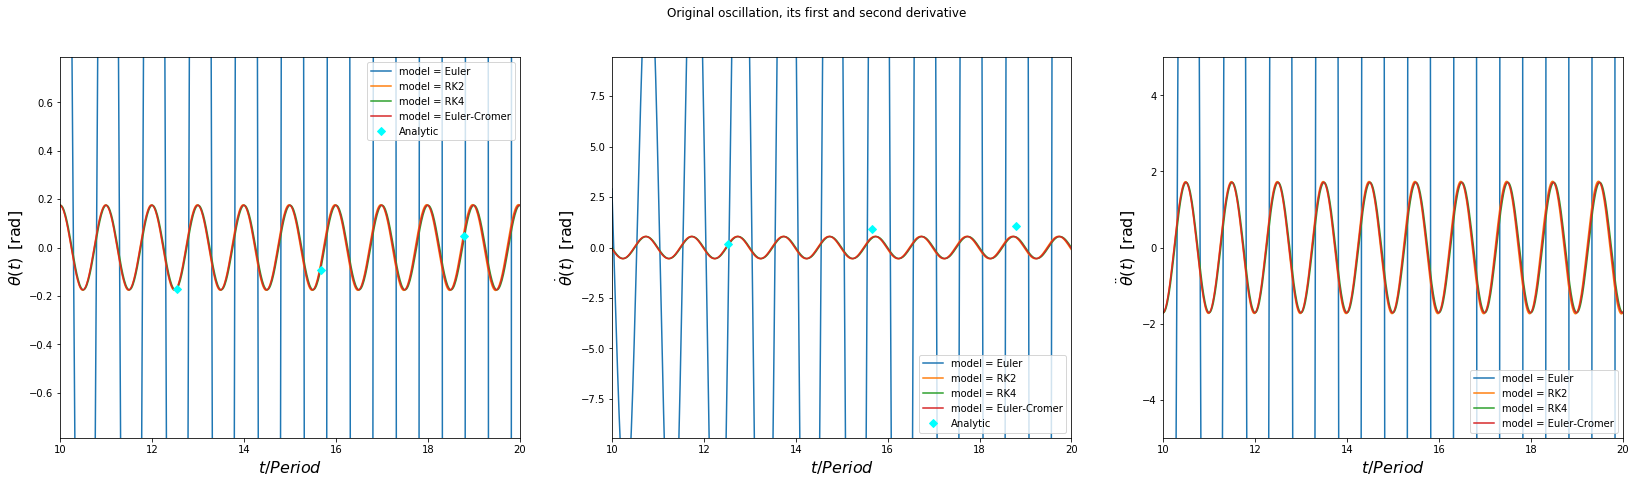

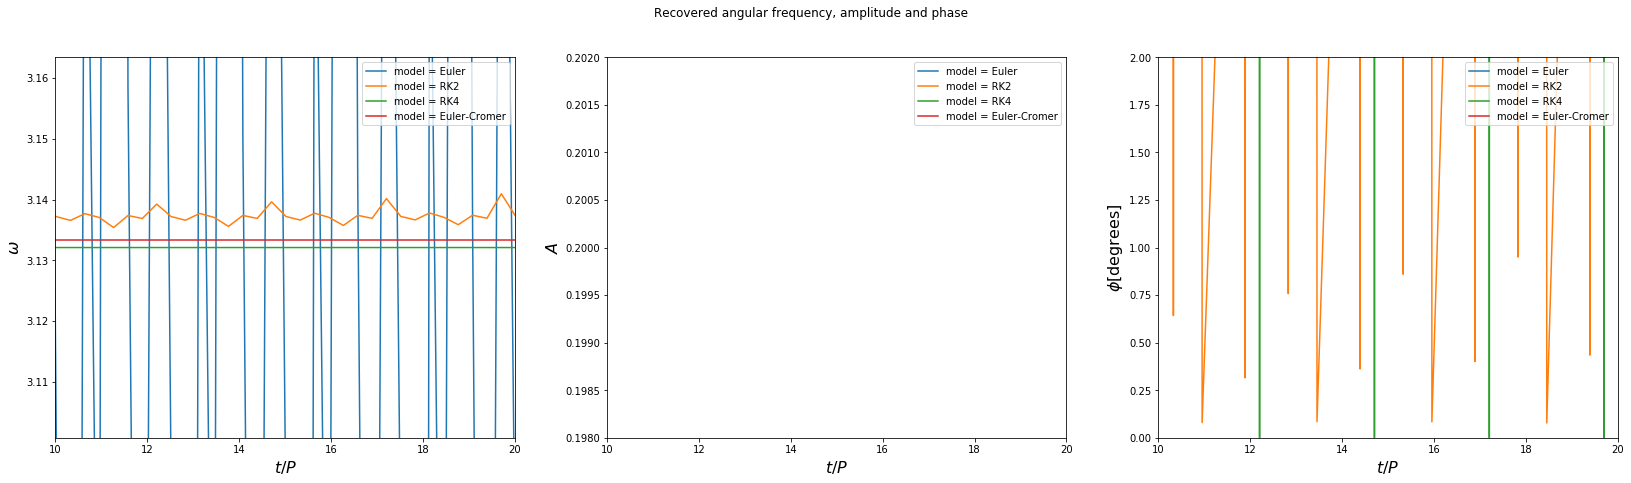

In [33]:
# Use this cell to compute angular frequency, amplitude and phase, given theta(t) obtained numerically
# Plot you results for each of the RK2, RK4 and EC solvers. Put the results on the same panel, using colours
#    and a legend to distinguish between them
# You may want to use the cell above for inspiration on how to compute 
#   the numerical detivative, and how to make the plot

# Examine how well the integrators work by plotting the results for time/period in the range [95,100[
# YOUR CODE HERE





"""
# These are the input values
phi_deg   = 25.0 # phase angle in degrees
omega     = 0.5
amplitude = 3.0
period    = 2.*np.pi/omega
t0        = 0
t1        = 10.*period

# Computed properties
dt        = period / 100.
phi       = phi_deg /180. * np.pi
t         = np.arange(t0, t1, dt)

# analytical relation
theta       = amplitude * np.cos(omega*t+phi)
dtheta_dt   = -omega*amplitude * np.sin(omega*t+phi)
ddtheta_dt2 = -omega**2 *amplitude * np.cos(omega*t+phi)
analytical  = {'t':t, 'theta':theta, 'dtheta_dt':dtheta_dt, 'ddtheta_dt2':ddtheta_dt2}
"""
fig, ax = plt.subplots(1, 3, figsize = (28, 7))
fig.suptitle('Original oscillation, its first and second derivative')




"""

# store the values of the pendulum as a dictionary

# parameters of the pendulum (gravity, Length, friction, driving force and frequency, non-linearity)                
pendulum_pars = {'g':phys_const["g"], 'L':1.0, 'q':0.0, 'F_D':0.0, 'Omega_D':0.0, 'non_linear':False}
dt         = Period(pendulum_pars) / 2**6
simulation = {'theta_deg':10, 't0':0, 't1': 100.*period, 'dt':dt}
"""


# store the values of the pendulum as a dictionary

# parameters of the pendulum (gravity, Length, friction, driving force and frequency, non-linearity)                
pendulum_pars = {'g':phys_const["g"], 'L':1.0, 'q':0.0, 'F_D':0.0, 'Omega_D':0.0, 'non_linear':False}
dt         = Period(pendulum_pars) / 2**6
simulation = {'theta_deg':10, 't0':0, 't1': 100.*period, 'dt':dt}


# Compute the period
def Period(pendulum):
    if (pendulum["non_linear"]):
        omega = pendulum["Omega_D"]
    else:
        omega = np.sqrt(pendulum["g"]/pendulum["L"])
    return 2.*np.pi/omega

period = Period(pendulum_pars)
print("Period of pendulum = ", period)

# simulation parameters: launch angle (degrees), starting and end time, time-step
# Notice that we define the timestep and the end time, in units of the period (unlike in the first part of the analysis)


# list of integration methods, in the form of (method, name)
methods = [(EulerSolver, 'Euler'), (RK2Solver,'RK2'), (RK4Solver,'RK4'), (EulerCromerSolver, 'Euler-Cromer')]

# The dictionary store the outcomes
# Notice the use of "method" to store results for a specific method
Results = {}
for method in methods:
    name       = method[1]
    solverType = method[0]

    # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                    F_D=pendulum_pars["F_D"], Omega_D=pendulum_pars["Omega_D"], 
                    nonlinear=pendulum_pars["non_linear"])

    # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] * np.pi / 180., 0])

    #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps()      # angle, dangle/dt
    print("Finished calculation for solver = ", name)

    # Store output. For each method, we create another dictionary for storing the outcome
    Results[method] = {}
    Results[method]['t']          = ts
    Results[method]['theta']      = theta
    Results[method]['dtheta_dt']  = dtheta_dt
    Results[method]['period']     = period














# Now we calculate the derivatives numberically from the theta(t) array
# (1) First create a spline fit to theta(t), using the scipy function
#     UnivariateSpline(
# (2) Given the spline fit, compute the derivatives *of the spline*
from scipy.interpolate import UnivariateSpline         # import the scipy routine





nplot    = len(methods)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.CMRmap(np.linspace(0., 1., nplot+1))))
cycle    = plt.rcParams['axes.prop_cycle'].by_key()['color']
nsys     = np.arange(nplot)

# 
handles  = []
handles2 = []
for (isys, method) in zip(nsys, methods):
    color  = cycle[isys]
    name   = method[1]
    label  = r"model = {}".format(name)   # label to differentiate between models
    #
    if (isys == 0):
        period = Results[method]["period"]
    t          = Results[method]['t']                   # divide by period ot make it dimensionless 
    theta      = Results[method]['theta']
    dtheta_dt  = Results[method]['dtheta_dt'] * period
    
    spl            = UnivariateSpline(t, theta, k=4, s=0)  # create spline fit
    dtheta_dt_sp   = spl.derivative(n=1)                   # create the first derivative of the spline
    dtheta_dt      = dtheta_dt_sp(t)                       #    and evaluate it at the x-values t
    ddtheta_dt2_sp = spl.derivative(n=2)                   # redo for the second derivative
    ddtheta_dt2    = ddtheta_dt2_sp(t)
    numerical      = {'t':t, 'theta':theta, 'dtheta_dt':dtheta_dt, 'ddtheta_dt2':ddtheta_dt2}
    print("###########\n",ddtheta_dt2)
    ax[0].plot(t/period, theta,     color=color, label=label)
    ax[1].plot(t/period, dtheta_dt, color=color, label=label)
    ax[2].plot(t/period, ddtheta_dt2, color=color, label=label)

    
# plot analytic solution
label       = 'Analytic'
nsteps      = 200
dt          = (simulation["t1"] - simulation["t0"]) / nsteps
times       = np.arange(simulation["t0"], simulation["t1"], dt)
omega       = 2.*np.pi / period    # angular frequency
theta       = simulation["theta_deg"] * np.pi/180. * np.cos(omega * times)
dtheta_dt   = -omega * simulation["theta_deg"] * np.pi/180. * np.sin(omega * times)
ax[0].plot(times/period, theta, 'D', color='cyan', label='Analytic')
ax[1].plot(times/period, period * dtheta_dt, 'D', color='cyan', label='Analytic')

    
ax[0].legend()
ax[1].legend()
ax[2].legend()
xrange = [10,20]
for i in np.arange(3):
    ax[i].set_xlim(xrange)
    ax[i].set_xlabel(r"$t / Period$")    

ax[0].set_ylim([-np.pi/4, np.pi/4])
ax[0].set_ylabel(r"$\theta(t)\,\,\,[{\rm rad}]$")

ax[1].set_ylim([-3*np.pi, 3*np.pi])
ax[1].set_ylabel(r"$ \dot\theta(t)\,\,\,[{\rm rad}]$")

ax[2].set_ylim([-5, 5])
ax[2].set_ylabel(r"$ \ddot\theta(t)\,\,\,[{\rm rad}]$")

fig.show()



fig, ax1 = plt.subplots(1, 3, figsize = (28, 7))
fig.suptitle('Recovered angular frequency, amplitude and phase')



nplot    = len(methods)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.CMRmap(np.linspace(0., 1., nplot+1))))
cycle    = plt.rcParams['axes.prop_cycle'].by_key()['color']
nsys     = np.arange(nplot)

# 
handles  = []
handles2 = []
for (isys, method) in zip(nsys, methods):
    color  = cycle[isys]
    name   = method[1]
    label  = r"model = {}".format(name)   # label to differentiate between models
    #
    if (isys == 0):
        period = Results[method]["period"]
    t          = Results[method]['t']                   # divide by period ot make it dimensionless 
    theta      = Results[method]['theta']
    dtheta_dt  = Results[method]['dtheta_dt'] * period
    
    spl            = UnivariateSpline(t, theta, k=4, s=0)  # create spline fit
    dtheta_dt_sp   = spl.derivative(n=1)                   # create the first derivative of the spline
    dtheta_dt      = dtheta_dt_sp(t)                       #    and evaluate it at the x-values t
    ddtheta_dt2_sp = spl.derivative(n=2)                   # redo for the second derivative
    ddtheta_dt2    = ddtheta_dt2_sp(t)
    numerical      = {'t':t, 'theta':theta, 'dtheta_dt':dtheta_dt, 'ddtheta_dt2':ddtheta_dt2}
    
    omega_sp  = np.sqrt(-numerical["ddtheta_dt2"]/numerical["theta"])
    A_sp      = np.sqrt(numerical["theta"]**2 + (numerical["dtheta_dt"]/omega_sp)**2)
    phi_sp    = -omega_sp * t + np.arctan2(-numerical["dtheta_dt"]/omega_sp, numerical["theta"])
    phi_sp    = np.mod(phi_sp, 2.*np.pi)  # limit to [0, 2pi]
    
    
    ax1[0].plot(numerical["t"][1::20]/period, omega_sp[1::20] , color=color, label=label)
    ax1[1].plot(numerical["t"][1::20]/period, A_sp[1::20] , color=color,label=label)
    ax1[2].plot(numerical["t"][1::20]/period, phi_sp[1::20]/np.pi*180., color=color,label=label)

for i in np.arange(3):
    ax1[i].set_xlim([10,20])
    ax1[i].set_xlabel(r"$t / P$")
ax1[0].legend()
ax1[1].legend()
ax1[2].legend()



ax1[0].set_ylim(omega * np.array([0.99, 1.01]))
ax1[0].set_ylabel(r"$\omega$")
ax1[1].set_ylim(0.2 * np.array([0.99, 1.01]))
ax1[1].set_ylabel(r"$A$")
ax1[2].set_ylim(1 + np.array([-1, 1]))
ax1[2].set_ylabel(r"$\phi [{\rm degrees}]$")

fig.show()

"""  







# First figure: compare theta(t), dtheta_dt(t), and ddtheta_dt2(t) between analytical input
#     and spline fits


model = analytical; label  = 'Harmonic'; color  = 'blue'
ax[0].plot(model["t"]/period, model["theta"], color=color, label=label)
ax[1].plot(model["t"]/period, model["dtheta_dt"], color=color, label=label)
ax[2].plot(model["t"]/period, model["ddtheta_dt2"], color=color, label=label)

model = numerical; label  = 'Spline'; color  = 'red'
ax[0].plot(model["t"]/period, model["theta"], '+', color=color, label=label)
ax[1].plot(model["t"]/period, model["dtheta_dt"], '+', color=color, label=label)
ax[2].plot(model["t"]/period, model["ddtheta_dt2"], '+', color=color, label=label)

for i in np.arange(3):
    ax[i].set_xlim([0,10])
    ax[i].set_xlabel(r"$t / P$")
ax[0].set_ylim(amplitude * np.array([-1.1, 1.1]))
ax[1].set_ylim(omega * amplitude * np.array([-1.1, 1.1]))
ax[2].set_ylim(omega**2 * amplitude * np.array([-1.1, 1.1]))

ax[0].set_ylabel(r"$\theta(t)$")
ax[1].set_ylabel(r"$\dot\theta(t)$")
ax[2].set_ylabel(r"$\ddot\theta(t)$")
ax[0].legend()
fig.show()








# From spline fit to theta(t), compute A, omega and phi
#    Note the use of a dictionary to prevent confusion over which method we are using
omega_sp  = np.sqrt(-numerical["ddtheta_dt2"]/numerical["theta"])
A_sp      = np.sqrt(numerical["theta"]**2 + (numerical["dtheta_dt"]/omega_sp)**2)
phi_sp    = -omega_sp * t + np.arctan2(-numerical["dtheta_dt"]/omega_sp, numerical["theta"])
phi_sp    = np.mod(phi_sp, 2.*np.pi)  # limit to [0, 2pi]








# Second figure: compare correct answer to that obtained from numerical derivatives
fig, ax = plt.subplots(1, 3, figsize = (28, 7))
fig.suptitle('Recovered angular frequency, amplitude and phase')

label = 'Harmonic'
ax[0].plot(numerical["t"]/period, omega + 0*np.array(numerical["t"]), color='blue', label=label)
ax[1].plot(numerical["t"]/period, amplitude + 0*np.array(numerical["t"]), color='blue')
ax[2].plot(numerical["t"]/period, phi_deg + 0*np.array(numerical["t"]), color='blue')

#
label = 'Spline'
ax[0].plot(numerical["t"][1::20]/period, omega_sp[1::20], '+', color='red', label=label)
ax[1].plot(numerical["t"][1::20]/period, A_sp[1::20], '+', color='red')
ax[2].plot(numerical["t"][1::20]/period, phi_sp[1::20]/np.pi*180., '+', color='red')
for i in np.arange(3):
    ax[i].set_xlim([0,5])
    ax[i].set_xlabel(r"$t / P$")
ax[0].legend()
ax[0].set_ylim(omega * np.array([0.99, 1.01]))
ax[0].set_ylabel(r"$\omega$")
ax[1].set_ylim(amplitude * np.array([0.99, 1.01]))
ax[1].set_ylabel(r"$A$")
ax[2].set_ylim(phi_deg + np.array([-1, 1]))
ax[2].set_ylabel(r"$\phi [{\rm degrees}]$")
"""  
    
fig.show()






In [20]:
import mywidgets
mcb4=mywidgets.myCheckBoxSet('Harmonic','EC',
                            'For this choice of the time step, which of the following assertions are true?',[
                                'The angular frequency of the EC solver is accurate to better than 1 per cent',
                                'The amplitude of the RK2 pendulum is correct to better than 5 per cent',
                                'The phase angle of the RK4 pendulum drifts by more than 5 degrees',
                            ])
mcb4.getWidget()


In [35]:
display(HTML('<hr>'))

Compare the analysis using the first method (where computation and plotting are excecuted in one single definition) 
with the analysis in the second method. What are the advantages/disadvantages of both? Which method would you use in case the calculation took some time? Discuss within your Team.


## Non-linear pendulum

Run the pendulum with the parameters below in the linear and the non-linear case. Use the EC integrator

In [36]:
# parameters
pendulum_pars = {'L':1.0, 'q':0.0, 'F_D':1.0, 'Omega_D':0.9}   # parameters of the pendulum
simulation    = {'t0':0, 't1':20, 'dt':0.01}                   # parameters of the simulation

# Run the EC for each of the linaerities below, and for each of these, for each of the launch angles theta0s
#     so 2 * 4 = 8 simulations in total
linearities   = [True, False]
theta0s       = [0.01, 0.02, 0.8, 1.2]                         # several choices for launch angle [radians]

# YOUR CODE HERE


[0.01 0.  ]
[0.01 0.  ]
[0.02 0.  ]
[0.02 0.  ]
[0.8 0. ]
[0.8 0. ]
[1.2 0. ]
[1.2 0. ]


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


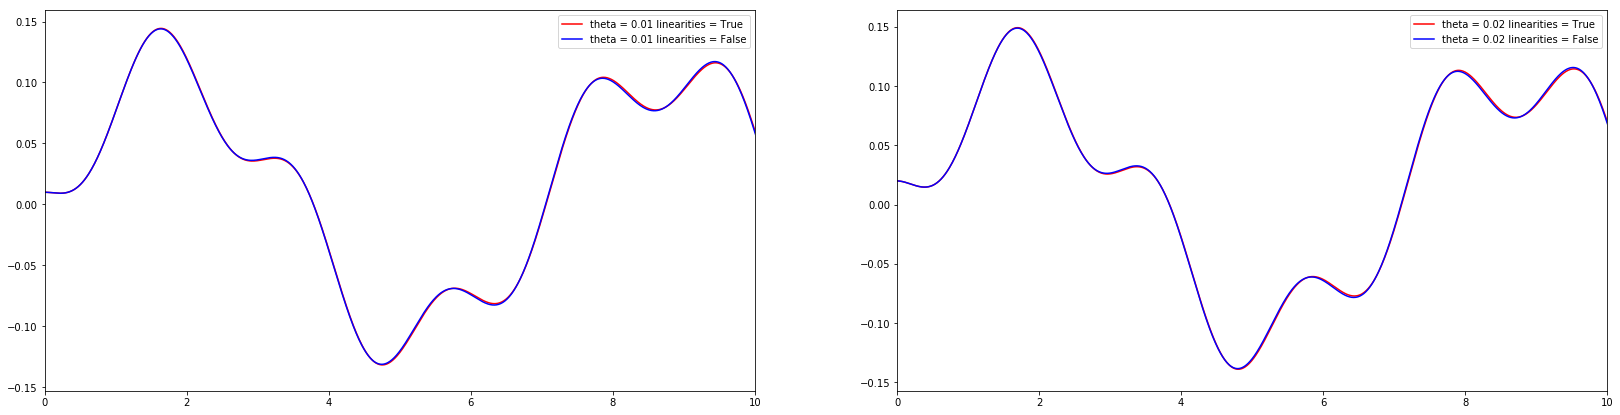

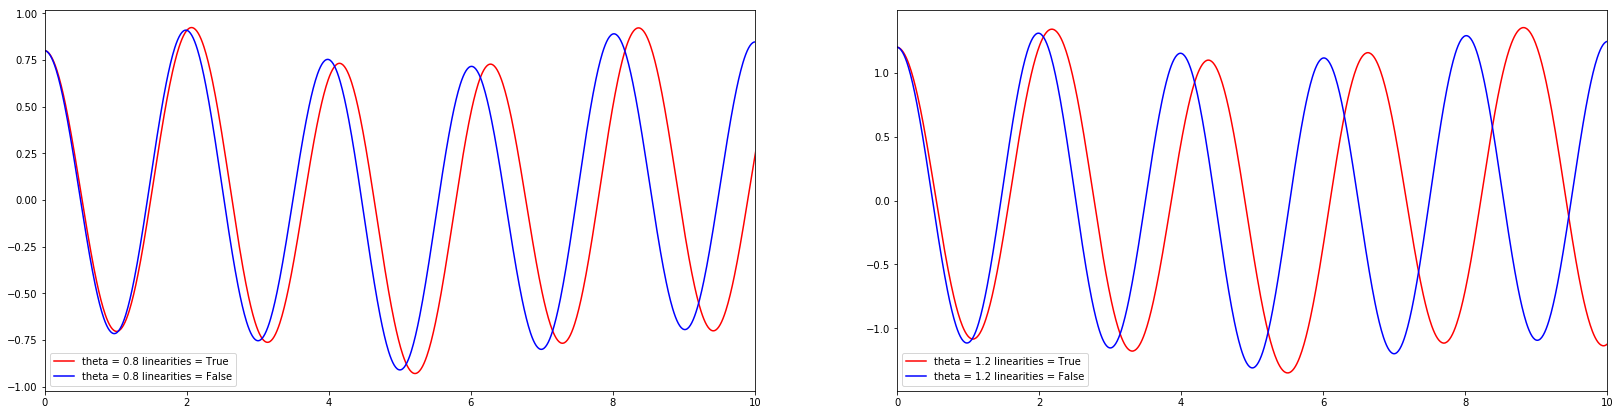

In [41]:
# Plot the results in four panels
#   each panel correponds to a given value of the launch angle
#   each panel plots the linear and corresponding non-linear evolution of theta(t)
#    use colours and/or linestyles to distinguish the linear evolution from the non-linear evolution
#   plot results over the time interval t in [0, 10]
# YOUR CODE HERE

# store the values of the pendulum as a dictionary
fig, ax = plt.subplots(1, 2, figsize = (28, 7))
fig, ax1 = plt.subplots(1, 2, figsize = (28, 7))

# parameters of the pendulum (gravity, Length, friction, driving force and frequency, non-linearity)                
pendulum_pars = {'g':phys_const["g"], 'L':1.0, 'q':0.0, 'F_D':1.0, 'Omega_D':0.9}
simulation = {'t0':0, 't1':20, 'dt':0.01}
color = ('red', 'blue')
for i in range(len(theta0s)):
    for j in range(len(linearities)):
        
        if linearities[j] == True:
            omega = pendulum_pars["Omega_D"]
            period = 2.*np.pi/omega
        else:
            omega = np.sqrt(pendulum_pars["g"]/pendulum_pars["L"])
            period = 2.*np.pi/omega

        # list of integration methods, in the form of (method, name)
        methods = [(EulerCromerSolver, 'Euler-Cromer')]

        # The dictionary store the outcomes
        # Notice the use of "method" to store results for a specific method
        Results = {}

        name       = method[1]
        solverType = method[0]

            # create an instance of pendulum from the class, setting the particular values for this run
        pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                            F_D=pendulum_pars["F_D"], Omega_D=pendulum_pars["Omega_D"], 
                            nonlinear=linearities[j])

            # this sets the initial conditions: initial dispacement, initial velocity = 0
        x0 = np.array([ theta0s[i], 0])
        print(x0)

            #simulation parameter
        solver           = solverType(pendulum)
        result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
        ts               = solver.timeSteps()
        theta, dtheta_dt = solver.coordinateSteps()      # angle, dangle/dt
       

        # Store output. For each method, we create another dictionary for storing the outcome
        #Results[method] = {}
        #Results[method]['t']          = ts
        #Results[method]['theta']      = theta
        #Results[method]['dtheta_dt']  = dtheta_dt
        #Results[method]['period']     = period
        
        if i==0:
            
            ax[0].plot(ts, theta,     color=color[j], label= "theta = "+str(theta0s[i])+" linearities = " + str(linearities[j]))
        if i==1:
            
            ax[1].plot(ts, theta,     color=color[j], label= "theta = "+str(theta0s[i])+" linearities = " + str(linearities[j]))
        if i==2:
            
            ax1[0].plot(ts, theta,     color=color[j], label= "theta = "+str(theta0s[i])+" linearities = " + str(linearities[j]))
        if i==3:
            
            ax1[1].plot(ts, theta,     color=color[j], label= "theta = "+str(theta0s[i])+" linearities = " + str(linearities[j]))
ax[0].legend()
ax[1].legend()
ax1[0].legend() 
ax1[1].legend()

for i in np.arange(2):
    ax1[i].set_xlim([0,10])
    
    ax[i].set_xlim([0,10])
   
    
fig.show()



In [21]:
import mywidgets
mcb5=mywidgets.myCheckBoxSet('Harmonic','NonLin',
                            'For this choice of the time step, which of the following assertions are true?',[
                                r"For launch angle $|\theta_0|<0.15$ there is barely a difference between linear and non-linear",
                                r"For launch angle $|\theta_0|<0.15$, the frequency does not depend strongly on launch angle",
                                r"For launch $|\theta_0|>=0.7$, the frequency depends on launch angle",
                            ])
mcb5.getWidget()


In [39]:
display(HTML('<hr>'))

## Playground

This is another exercise; there are no marks associated with it.
Consider the following modification to the EC-solver, called **leapfrog**

$$ \phi^{n+1} = \phi^n + \omega^{n+1/2} \Delta t$$
$$ \omega^{n+3/2} = \omega^{n+1/2} + f(\phi^n) \Delta t$$


The first line - updating the position given the velocity, is called the **drift**.
The second line - updating the velocity given the acceleration, is called the **kick**.

Notice how position and velocity are always offset by 1/2 of a timestep, $\Delta t$.

Note that, to get started, this requires calculating $\omega^{1/2}$ from the initial velocity, $\omega^0$.

Implement this leapfrog scheme, and check for energy conservation. **Beware**: you need to calculate the potential energy and the kinetic energy **at the same time**. So you will need to perform either 1/2 a drift, or 1/2 a kick.

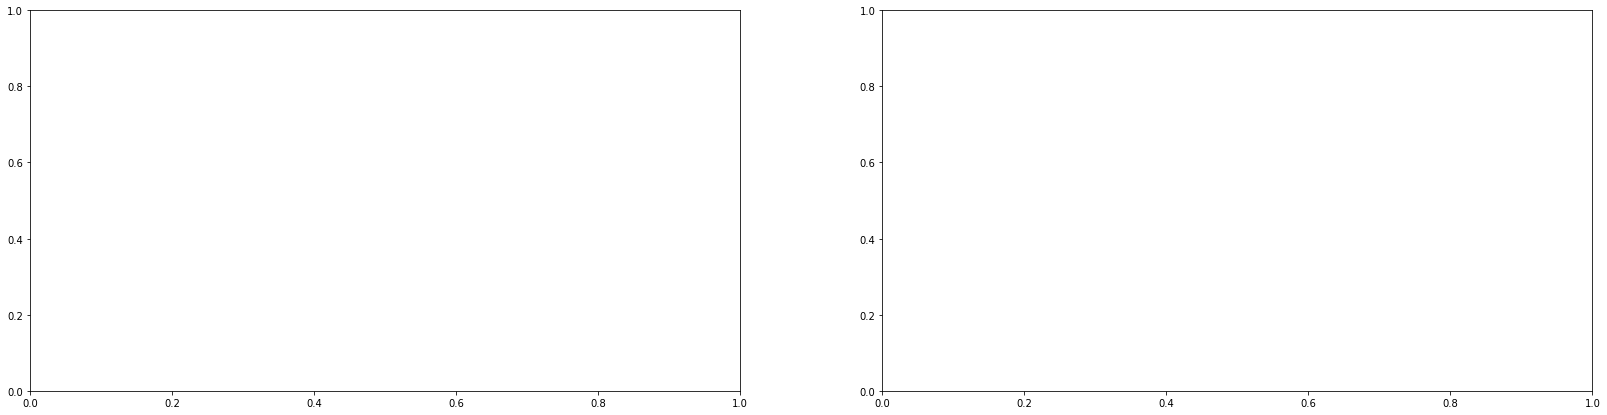

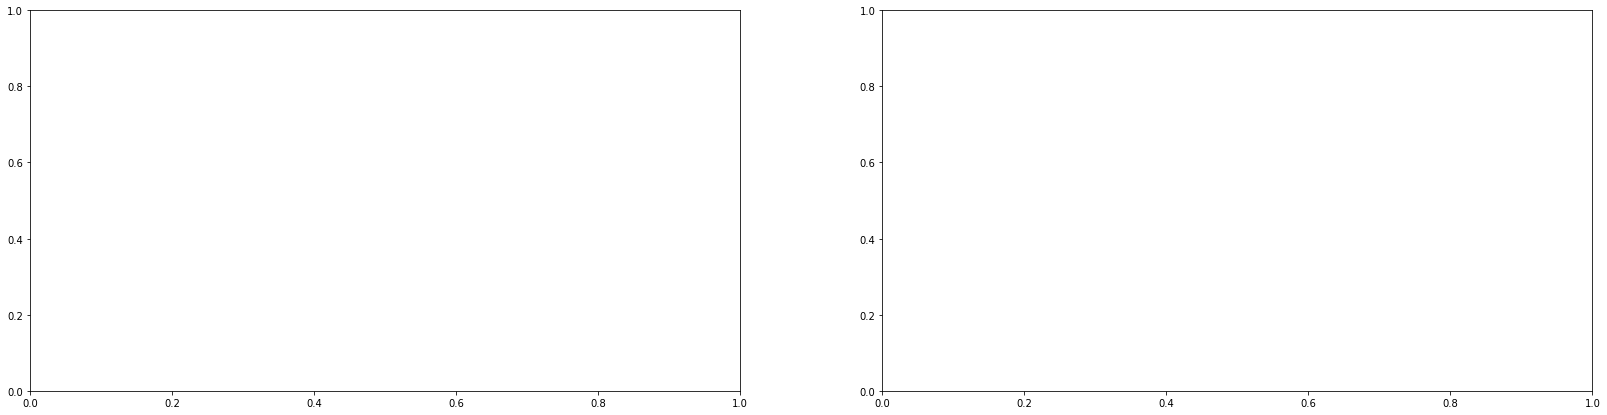

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (28, 7))
fig, ax1 = plt.subplots(1, 2, figsize = (28, 7))